# Objective:

To collect insight into what influences conversion of users of old vs new landing pages.

We will be focusing on asnwering the following questions - 

* Do the users spend more time on the new landing page than the old landing page?
* Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?
* Does the converted status depend on the preferred language? 
* Is the mean time spent on the new page same for the different language users?
* Is the new landing page more effective to gather new subscribers than the old landing page?


# Data:
**abtest.csv** - it contains information about users visiting a website.
* user_id - This represents the user ID of the person visiting the website.
* group - This represents whether the user belongs to the first group (control) or the second group (treatment).
* landing_page - This represents whether the landing page is new or old.
* time_spent_on_the_page - This represents the time (in minutes) spent by the user on the landing page.
* converted - This represents whether the user gets converted to a subscriber of the news portal or not.
* language_preferred - This represents the language chosen by the user to view the landing page.

### Import the necessary packages

In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind, chi2_contingency, levene, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Read the dataset

In [221]:
df = pd.read_csv('abtest.csv')
# copying data to another varaible to avoid any changes to original data
abtest = df.copy()

### View the first and last 5 rows of the dataset.

In [222]:
abtest.head()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish


In [223]:
abtest.tail()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
95,546446,treatment,new,5.15,no,Spanish
96,546544,control,old,6.52,yes,English
97,546472,treatment,new,7.07,yes,Spanish
98,546481,treatment,new,6.20,yes,Spanish
99,546483,treatment,new,5.86,yes,English


### Understand the shape of the dataset.

In [224]:
abtest.shape

(100, 6)

* Dataset has 100 rows and 6 columns.

### Check the data types of the columns for the dataset.

In [225]:
abtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 100 non-null    int64  
 1   group                   100 non-null    object 
 2   landing_page            100 non-null    object 
 3   time_spent_on_the_page  100 non-null    float64
 4   converted               100 non-null    object 
 5   language_preferred      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


## Fixing the data types

* Group, landing page, converted, and language preferred are of object type, we can change them to categories.

`coverting "objects" to "category" reduces the data space required to store the dataframe`

In [226]:
abtest["group"] = abtest["group"].astype("category")
abtest["landing_page"] = abtest["landing_page"].astype("category")
abtest["converted"] = abtest["converted"].astype("category")
abtest["language_preferred"] = abtest["language_preferred"].astype("category")

In [227]:
abtest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   user_id                 100 non-null    int64   
 1   group                   100 non-null    category
 2   landing_page            100 non-null    category
 3   time_spent_on_the_page  100 non-null    float64 
 4   converted               100 non-null    category
 5   language_preferred      100 non-null    category
dtypes: category(4), float64(1), int64(1)
memory usage: 2.5 KB


* Group, landing page, converted, and language preferred have been converted to categories

`we can see that the memory usage has decreased from 4.8+ KB to 2.5KB`

### Give a statistical summary for the dataset.

In [228]:
abtest.describe()

,user_id,time_spent_on_the_page
count,100.000000,100.000000
mean,546517.000000,5.377800
std,52.295779,2.378166
min,546443.000000,0.190000
25%,546467.750000,3.880000
50%,546492.500000,5.415000
75%,546567.250000,7.022500
max,546592.000000,10.710000


* Time spent on the page is the only variable of value from this summary.
* The mean and the median are very close in value which indicates the data set is evenly distributed.
* Users spend anywhere from 0.19 to 10.7 min on either page.

In [229]:
abtest.describe(include=["category"])

,group,landing_page,converted,language_preferred
count,100,100,100,100
unique,2,2,2,3
top,treatment,old,yes,Spanish
freq,50,50,54,34


* Half of the users in the sample were assigned to the control group while the other half are treatment.
* Half of the users in the sample use the old landing page.
* More users converted to subscriber(54) than users who did not convert(46).
* Spanish is the most preferred language.

### Check for missing values

In [230]:
abtest.isnull().sum()

user_id                   0
group                     0
landing_page              0
time_spent_on_the_page    0
converted                 0
language_preferred        0
dtype: int64

* There are no missing values in the data.

### EDA

### Univariate analysis

In [231]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency 
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical 
# variable.
# This function takes the numerical column as the input and returns the boxplots 
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=F, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.distplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

## Observations on Time Spent on the Page

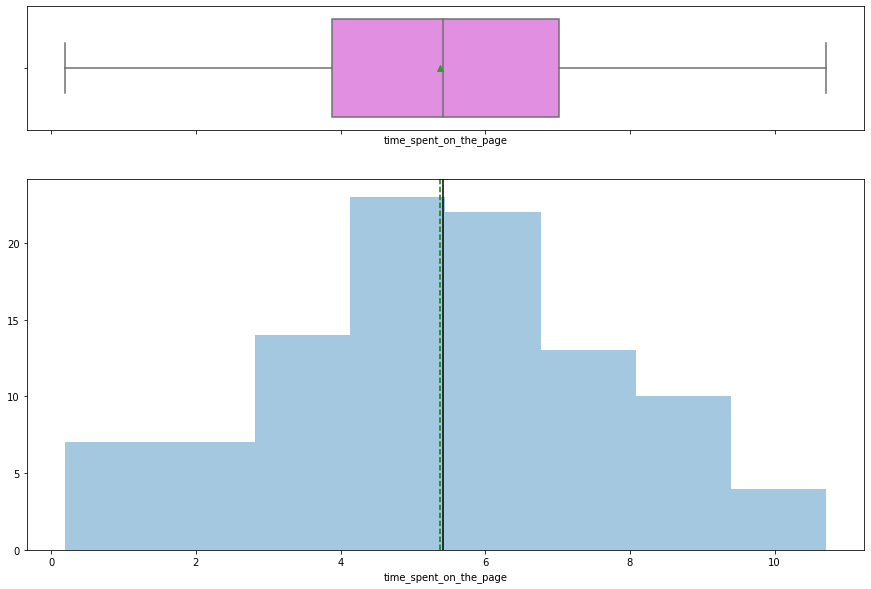

In [232]:
histogram_boxplot(abtest["time_spent_on_the_page"])

* As expected based on the summary data above, the time spent on the page is uniformly distributed.
* The mean and the median are very close to the same value around the center of the dataset.	
* There are no outliers present in the dataset.

In [233]:
# Function to create barplots that indicate percentage for each category.

def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

## Observations on Group

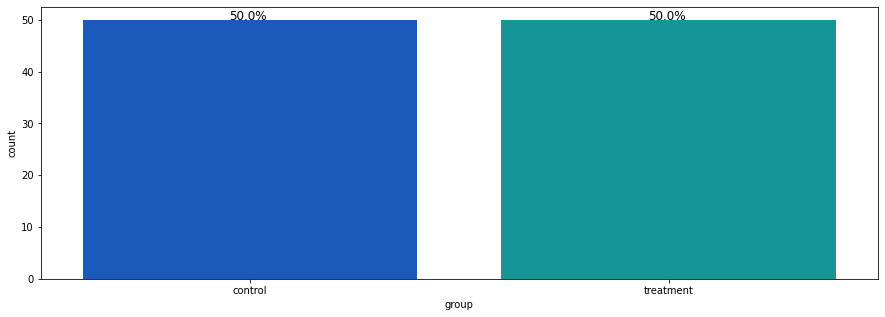

In [234]:
plt.figure(figsize=(15,5))
ax = sns.countplot(abtest["group"],palette='winter')
perc_on_bar(ax,abtest["group"])

* The sample data is equally distributed between control and treatment groups

## Observations on Landing Page

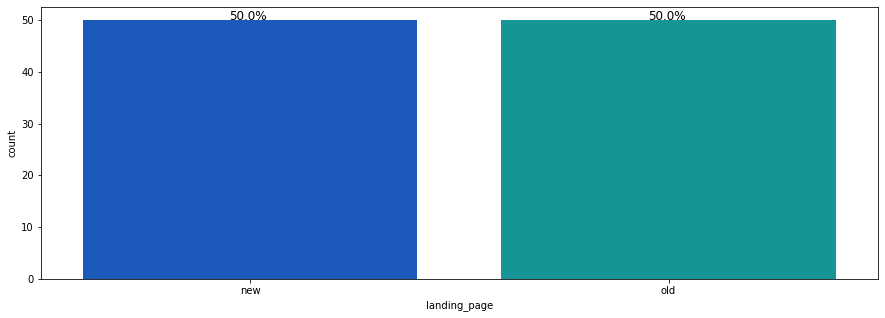

In [235]:
plt.figure(figsize=(15,5))
ax = sns.countplot(abtest["landing_page"],palette='winter')
perc_on_bar(ax,abtest["landing_page"])

* The sample data is equally distributed between new and old landing pages

## Observations on Converted

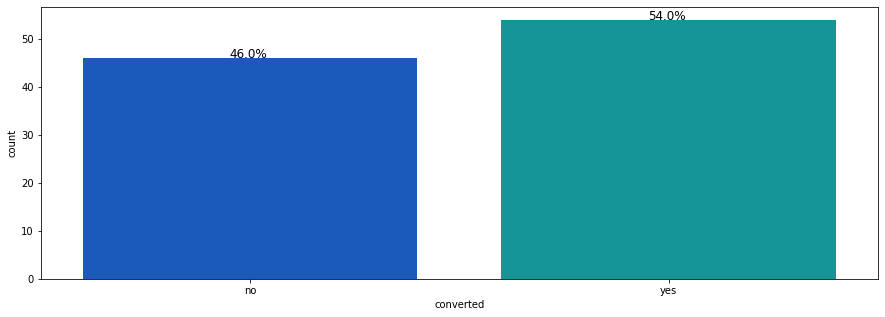

In [236]:
plt.figure(figsize=(15,5))
ax = sns.countplot(abtest["converted"],palette='winter')
perc_on_bar(ax,abtest["converted"])

* There are more users who converted to subscribed users

## Observations on Language Preferred

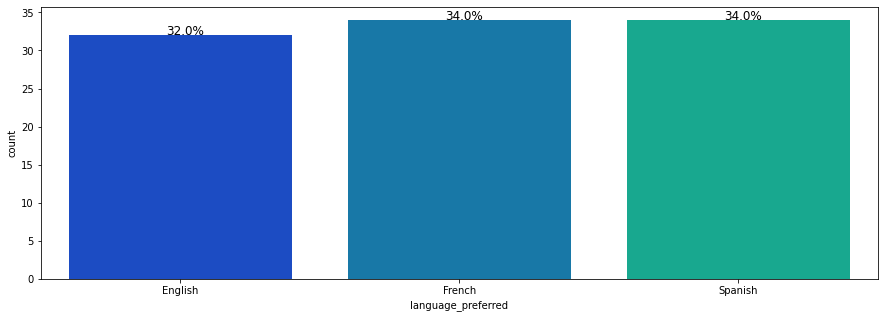

In [237]:
plt.figure(figsize=(15,5))
ax = sns.countplot(abtest["language_preferred"],palette='winter')
perc_on_bar(ax,abtest["language_preferred"])

* There are more users who prefer Spanish and French over English

## Bivariate Analysis

### Time Spent on the Page vs Language Preferred

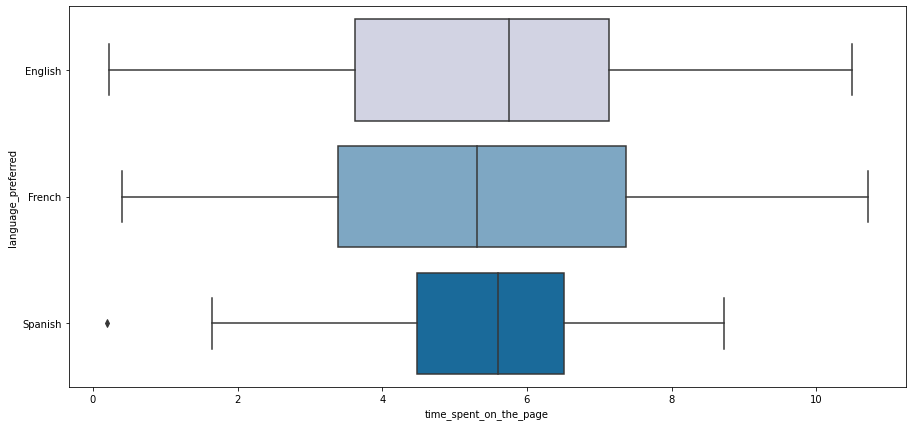

In [238]:
plt.figure(figsize=(15,7))
sns.boxplot(abtest["time_spent_on_the_page"],abtest["language_preferred"],palette="PuBu")
plt.show()

* Users who prefer Spanish spend a more consistent amount of time on the site with one outlier.
* Users who prefer English will on average spend more time on the site.
* Users who prefer French vary more on the amount of time spent on the site.

### Time Spent on the Page vs Converted

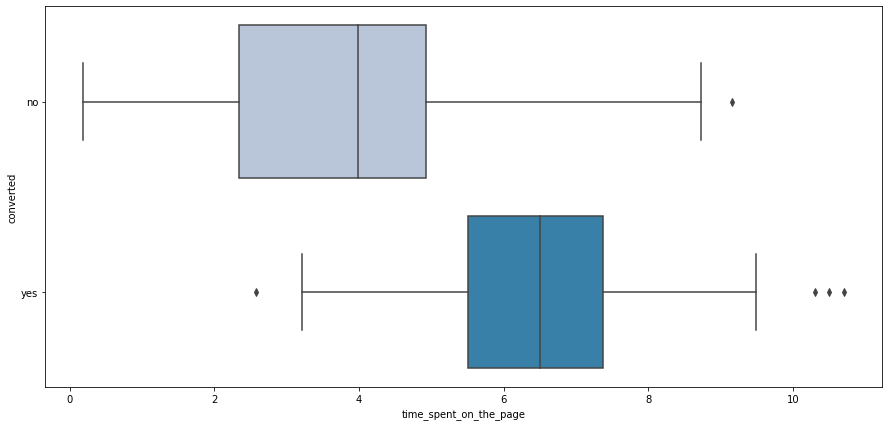

In [239]:
plt.figure(figsize=(15,7))
sns.boxplot(abtest["time_spent_on_the_page"],abtest["converted"],palette="PuBu")
plt.show()

* Users who spent more time on the site also converted to subscribe.

### Time Spent on the Page vs Group

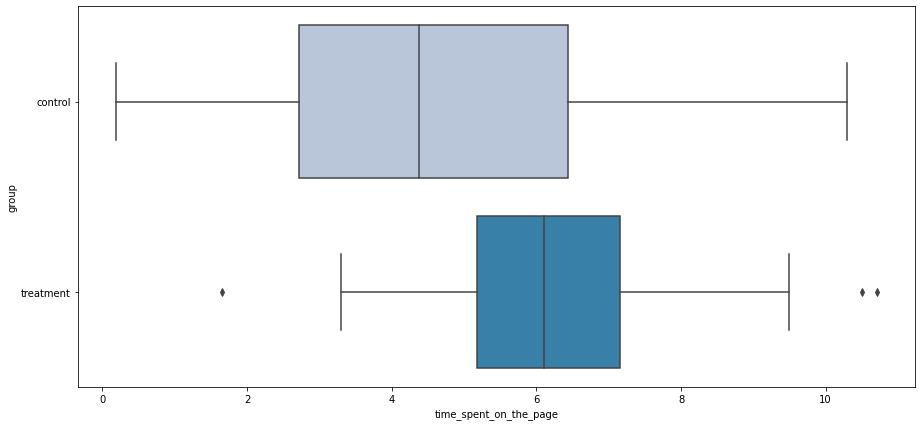

In [241]:
plt.figure(figsize=(15,7))
sns.boxplot(abtest["time_spent_on_the_page"],abtest["group"],palette="PuBu")
plt.show()

* Users in the treatment group on average spend more time on the site.
* Users in the control group have a wider range of time spent on the site.

## Do the users spend more time on the new landing page than the old landing page?

Defining the null and alternative hypothesis:

>$H_0:$ Users spend an equal amount of time on the new landing page that they do on the old page

>$H_a:$ Users spend more time on the new landing page than the old landing page

In [276]:
# find the sample means and sample standard deviations for the two samples
print('The mean time spent on the new landing page is ' + str(abtest['time_spent_on_the_page'][abtest['landing_page']=="new"].mean()))
print('The mean time spent on the old landing page is ' + str(abtest['time_spent_on_the_page'][abtest['landing_page']=="old"].mean()))
print('The standard deviation of time spent on the new landing page is ' + str(round(abtest['time_spent_on_the_page'][abtest['landing_page']=="new"].std(), 2)))
print('The standard deviation of time spent on the old landing page is ' + str(round(abtest['time_spent_on_the_page'][abtest['landing_page']=="old"].std(), 2)))

The mean time spent on the new landing page is 6.2232
The mean time spent on the old landing page is 4.532400000000001
The standard deviation of time spent on the new landing page is 1.82
The standard deviation of time spent on the old landing page is 2.58


### Testing whether T-test assumptions are satisfied or not

* Continuous data - Yes, time spent on the landing page is measured on a continuous scale.
* Normally distributed populations - Yes, the populations are assumed to be normal.
* Independent populations - As we are taking random samples for two different groups, the two samples are from two independent populations.
* Unequal population standard deviations - As the sample standard deviations are different, the population standard deviations may be assumed to be different.
* Random sampling from the population - Yes, we assume that the collected sample a simple random sample.

We can use two sample T-test for this problem.

### Time Spent on the Page vs Landing Page

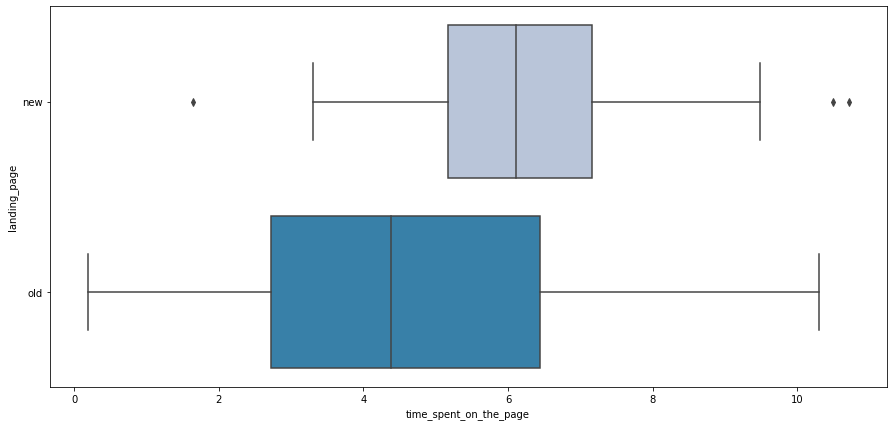

In [279]:
plt.figure(figsize=(15,7))
sns.boxplot(abtest["time_spent_on_the_page"],abtest["landing_page"],palette="PuBu")
plt.show()

In [278]:
# find the p-value
test_stat, p_value = ttest_ind(abtest['time_spent_on_the_page'][abtest['landing_page']=="new"], abtest['time_spent_on_the_page'][abtest['landing_page']=="old"].dropna(), equal_var = False, alternative = 'greater')
print('The p-value is ', p_value)

The p-value is  0.0001392381225166549


* As the p-value (~0.00013) is less than the level of significance, we can reject the null hypothesis. Hence, we can conclude that users spend more time on the new landing page than the old landing page.

# Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?

Defining the null and alternative hypothesis:

>$H_0:$ The conversion rate for the new page is equal to the conversion rate for the old page

>$H_a:$ The conversion rate for the new page is greater than the conversion rate for the old page

The formulated hypotheses are concerned with proportions. A test of proportions can be used to analyse the hypotheses and draw a conclusion. Therefore we can use a proportions Z test for this problem.

## Observations on Conversion

In [242]:
# number of conversions on the new landing page
converted_new = abtest[abtest['landing_page']=='new'].converted.value_counts()['yes']
# number of conversions on the old landing page
converted_old = abtest[abtest['landing_page']=='old'].converted.value_counts()['yes']

print('The numbers of new and old page conversions are {0} and {1} respectively'.format(converted_new, converted_old))

# number of new page visits in the data
n_new = abtest.landing_page.value_counts()['new']

# number of old page visits
n_old = abtest.landing_page.value_counts()['old']

print('The total numbers of new and old page visits are {0} and {1} respectively'.format(n_new, n_old))

The numbers of new and old page conversions are 33 and 21 respectively
The total numbers of new and old page visits are 50 and 50 respectively


In [243]:
print(f' The proportions of new and old page conversions are {round(115/662,2)}, {round(159/676,2)} respectively')

 The proportions of new and old page conversions are 0.17, 0.24 respectively


In [244]:
# find the p-value using proportion_ztest
stat, pval = proportions_ztest([converted_new, converted_old] , [n_new, n_old], alternative = 'larger')

# print the p-value
print('The p-value is '+ str(pval))

The p-value is 0.008026308204056278


In [245]:
# print the conclusion based on p-value
if pval < 0.05:
    print(f'As the p-value {pval} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {pval} is greater than the level of significance, we fail to reject the null hypothesis.')

As the p-value 0.008026308204056278 is less than the level of significance, we reject the null hypothesis.


* The conversion rate for the new page is greater than the conversion rate for the old page

# Does the converted status depend on the preferred language?

In [246]:
data_crosstab = pd.crosstab(abtest['converted'], abtest['language_preferred'], margins = False)
print(data_crosstab)

language_preferred  English  French  Spanish
converted                                   
no                       11      19       16
yes                      21      15       18


### Observation on Language Preferred - Contingency Table

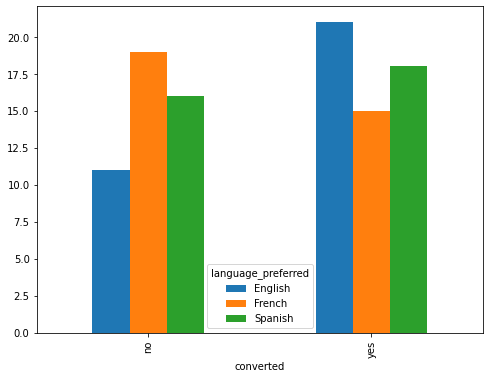

In [247]:
data_crosstab.plot(kind='bar', stacked=False, figsize = (8,6))
plt.show()

Defining the null and alternative hypothesis:

>$H_0:$ The converted status is dependent on the preferred language

>$H_a:$ The converted status is NOT dependent on the preferred language

The formulated hypotheses can be tested using a Chi-square test of independence of attributes, concerning the two categorical variables, converted or not converted.

In [248]:
# use chi2_contingency() to find the p-value
chi2, pval, dof, exp_freq = chi2_contingency(data_crosstab)
# print the p-value
print('The p-value is', pval)

The p-value is 0.21298887487543447


In [249]:
# print the conclusion based on p-value
if pval < 0.05:
    print(f'As the p-value {pval} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {pval} is greater than the level of significance, we fail to reject the null hypothesis.')

As the p-value 0.21298887487543447 is greater than the level of significance, we fail to reject the null hypothesis.


* Since the p-value is > 0.05, we fail to reject the null hypothesis. Hence, we do not have enough statistical evidence to say that the convert status is not independent on the preferred language.

# Is the mean time spent on the new page same for the different language users?

Defining the null and alternative hypothesis:

>$H_0: \mu_1 = \mu_2 = \mu_3$

>$H_a:$ The mean time spent on the new page is different for the different language users.

* For multiple comparison testing, we will use Tukey HSD

In [250]:
abtest_new = abtest[abtest['landing_page'] == 'new'] #Creating a new dataframe that contains users who used only the new landing page
abtest_new.head()

,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
4,546459,treatment,new,4.75,yes,Spanish
6,546448,treatment,new,5.25,yes,French
8,546461,treatment,new,10.71,yes,French


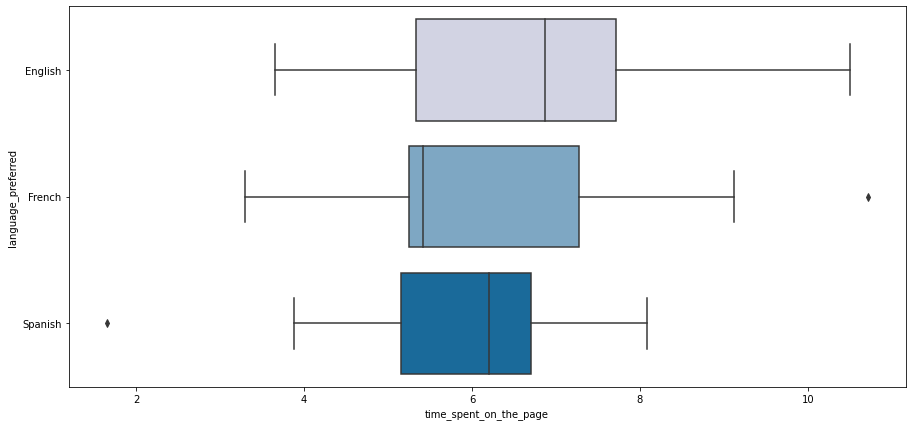

In [251]:
plt.figure(figsize=(15,7))
sns.boxplot(abtest_new["time_spent_on_the_page"],abtest_new["language_preferred"],palette="PuBu")
plt.show()

In [264]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog = abtest_new['time_spent_on_the_page'], groups = abtest_new['language_preferred'], alpha = 0.05)
print(m_comp)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
English  French  -0.4673 0.7259 -2.0035  1.069  False
English Spanish  -0.8285  0.401 -2.3647 0.7078  False
 French Spanish  -0.3612  0.816  -1.874 1.1516  False
-----------------------------------------------------


* As the p-values (refer to the p-adj column) for comparing the mean time spent on the page are all greater than the significance level, the null hypothesis of equality of all population means can be rejected.

* Thus, we can say that the mean time spent on the new page is not dependent on the language preference of the user.